In [15]:
import os
import cv2
import shutil
import numpy as np

In [16]:
import nbimporter
from monster_dataset import CanDataset, transform
from torch.utils.data import DataLoader, Dataset

In [14]:
import os
import random
from PIL import Image, ImageFilter
import numpy as np

def apply_random_transform(image):
    """Applica una trasformazione casuale all'immagine."""
    
    # Assicurati che l'immagine sia in modalità RGB (o RGBA se ha canali alfa)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    if random.random() < 0.5:  # 50% di probabilità di applicare una modifica
        # Applica una sfocatura casuale
        image = image.filter(ImageFilter.GaussianBlur(radius=random.uniform(1, 5)))
    
    return image

def process_images_in_folder(folder_path):
    """Elabora le immagini in una cartella e applica modifiche casuali al 50%."""
    # Ottieni l'elenco di tutte le immagini nella cartella
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'png', 'jpeg'))]
    
    # Elaboriamo il 50% delle immagini
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)
        
        # Applica la trasformazione casuale
        modified_image = apply_random_transform(image)
        
        # Salva l'immagine modificata con un suffisso "_modified"
        modified_image_path = os.path.join(folder_path, f"modified_{image_file}")
        modified_image.save(modified_image_path)
        
        # Rimuovi l'immagine originale
        os.remove(image_path)

def process_dataset(dataset_path):
    """Processa tutte le immagini nel dataset, applicando modifiche casuali."""
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        
        # Assicurati che sia una cartella
        if os.path.isdir(category_path):
            print(f"Processing category: {category}")
            process_images_in_folder(category_path)

# Percorso del tuo dataset (modifica con il percorso reale)
train_path = "/home/alejandro/.cache/kagglehub/datasets/tmmarquess/monster-energy-drink/versions/2/Monster_energy_drink_png/Monster_energy_drink/train"
test_path = "/home/alejandro/.cache/kagglehub/datasets/tmmarquess/monster-energy-drink/versions/2/Monster_energy_drink_png/Monster_energy_drink/test"

# Elabora tutto il dataset
print('Transform train dataset')
process_dataset(train_path)
print('Transform test dataset')
process_dataset(test_path)

Transform train dataset
Processing category: ultra peachy keen
Processing category: nitro super dry
Processing category: ultra blue
Processing category: ultra black


/home/alejandro/Desktop/Projects/signals/MonsterRecognition/monster/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processing category: tea lemonade
Processing category: ultra watermelon
Processing category: ultra violet
Processing category: ultra rosa
Processing category: Original green
Processing category: java salted caramel
Processing category: Mango Loco
Processing category: ultra strawberry dreams
Processing category: Pacific Punch
Processing category: nitro cosmic peach
Processing category: lo carb
Processing category: ultra gold
Processing category: Aussie Lemonade
Processing category: ultra red
Processing category: ultra sunrise
Transform test dataset
Processing category: ultra peachy keen
Processing category: nitro super dry
Processing category: ultra blue
Processing category: ultra black
Processing category: tea lemonade
Processing category: ultra watermelon
Processing category: ultra violet
Processing category: ultra rosa
Processing category: Original green
Processing category: java salted caramel
Processing category: Mango Loco
Processing category: ultra strawberry dreams
Processing ca

In [17]:
train_dataset = CanDataset(root_dir='/home/alejandro/.cache/kagglehub/datasets/tmmarquess/monster-energy-drink/versions/2/Monster_energy_drink_png/Monster_energy_drink/train', transform=transform)
test_dataset = CanDataset(root_dir='/home/alejandro/.cache/kagglehub/datasets/tmmarquess/monster-energy-drink/versions/2/Monster_energy_drink_png/Monster_energy_drink/test', transform=transform)

# Crea i dataloader per il dataset di train e test
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
import torch
import torch.nn as nn

# Definisci il dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica il modello pre-addestrato ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modifica l'ultimo layer per adattarlo al numero di classi del dataset
num_features = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes) # model.fc è l'ultimo layer fully connected della ResNet

# Sposta il modello sul dispositivo
model = model.to(device)

# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss() # Loss function adatta ai problemi di classificazione multi-classe.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the list to store loss values
loss_values = []

# Funzione per addestrare il modello
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Azzerare i gradienti
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass e ottimizzazione
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Salva i valori di perdita in un file
    metrics = {
        'loss_values': loss_values,
        'num_epochs': 5,
        'learning_rate': 0.001,
        'optimizer_state_dict': optimizer.state_dict(),
        'model_state_dict': model.state_dict()
    }
    torch.save(metrics, 'model_metrics.pth')

# Addestra il modello e ottieni i valori di perdita
train_model(model, train_loader, criterion, optimizer, num_epochs=5)


Epoch 1/5, Loss: 1.3345
Epoch 2/5, Loss: 0.8927
Epoch 3/5, Loss: 0.6556
Epoch 4/5, Loss: 0.5317
Epoch 5/5, Loss: 0.4174


In [19]:
#CELLA DI CONTROLLO
metrics = torch.load('model_metrics.pth')
loss_values = metrics['loss_values']
print("Loss values:", loss_values)
print("Numero di valori:", len(loss_values))

Loss values: [1.3344512594507096, 0.8926802283905922, 0.6556387179075404, 0.5316961959321448, 0.4174460771870106]
Numero di valori: 5


/tmp/ipykernel_53320/1050678345.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics = torch.load('model_metrics.pth')


/tmp/ipykernel_53320/1588597469.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics = torch.load('model_metrics.pth')


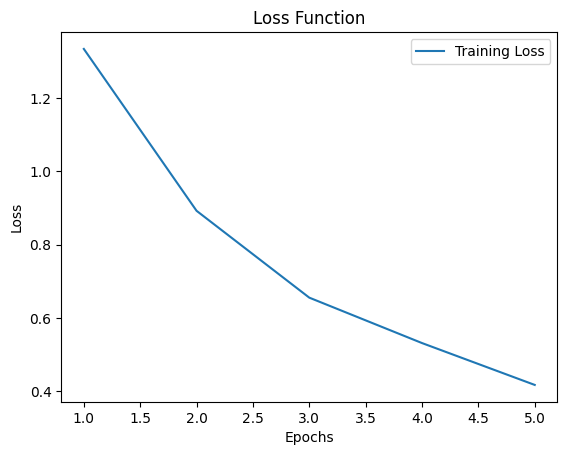

In [20]:
import torch

import matplotlib.pyplot as plt

# Carica i dati dal file
metrics = torch.load('model_metrics.pth')

# Estrai i valori di perdita e il numero di epoche
loss_values = metrics['loss_values']
num_epochs = metrics['num_epochs']

# Crea l'asse x con il numero di epoche
epochs = range(1, num_epochs + 1)

# Plot dei valori di perdita
plt.plot(epochs, loss_values[:num_epochs], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.legend()
plt.show()

In [28]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    test_loss = test_loss / len(test_loader)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Load the model state dict from the saved metrics
model.load_state_dict(metrics['model_state_dict'])

# Evaluate the model on the test dataset
evaluate_model(model, test_loader, criterion)

NameError: name 'criterion' is not defined

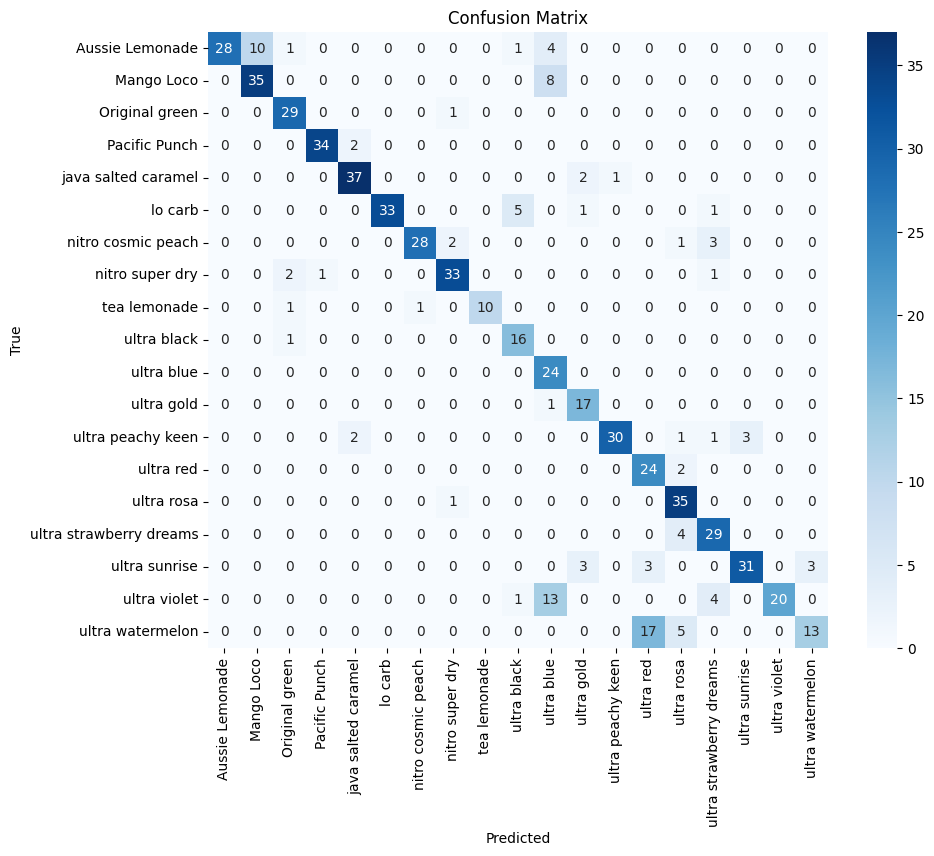

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
model_state_dict
# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, train_dataset.classes)

In [25]:
# Importa i moduli necessari
from torchvision import models
import torch.nn as nn
import torch

data = torch.load('model_metrics.pth', map_location=torch.device('cpu'))  # Usa 'cpu' o 'cuda' a seconda del dispositivo

# Estrai solo model_state_dict
model_state_dict = data['model_state_dict']

## Definisci il dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica il modello pre-addestrato ResNet-50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modifica l'ultimo layer per adattarlo al numero di classi del dataset
num_features = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes) # model.fc è l'ultimo layer fully connected della ResNet
print()
# Carica i pesi salvati
model.load_state_dict(model_state_dict)

# Passa il modello in modalità di valutazione
model.eval()

# Ora il modello è pronto per essere usato per inferenza

/tmp/ipykernel_53320/1093679600.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('model_metrics.pth', map_location=torch.device('cpu'))  # Usa 'cpu' o '

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
import cv2
import torch
import torchvision.transforms as transforms

# Percorso dell'immagine
image_path = "bounded_images/cropped_image_0.jpeg"

# Leggi l'immagine con OpenCV
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti da BGR a RGB

# Definisci le trasformazioni per adattare l'immagine a ResNet-50
transform = transforms.Compose([
    transforms.ToPILImage(),  # Converti l'immagine NumPy in un'immagine PIL
    transforms.Resize((224, 224)),  # Ridimensiona l'immagine a 224x224
    transforms.ToTensor(),  # Converti in tensore PyTorch
    transforms.Normalize(  # Normalizza con i valori medi e std di ImageNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Applica le trasformazioni
inputs = transform(image).unsqueeze(0)  # Aggiungi una dimensione batch

# Sposta l'immagine sul dispositivo (CPU o GPU)
inputs = inputs.to(device)

# Disattiva il calcolo del gradiente per ottimizzare le prestazioni
with torch.no_grad():
    outputs = model(inputs)

# Calcola le probabilità e ottieni le classi predette
probabilities = torch.nn.functional.softmax(outputs, dim=1)
predicted_classes = torch.argmax(probabilities, dim=1)

print("Predicted Classes:", predicted_classes.item())


Predicted Classes: 14
